In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
  

Using TensorFlow backend.


In [2]:
# from nltk import word_tokenize 
# stop_words = set(stopwords.words('english'))
# def listtosen(l):
#     new = ""
#     for x in l:
#         new+=x
#         new+=' '
#     return new
# def rem_stopwords(s):
    
#     word_tokens = word_tokenize(s) 
  
#     filtered_sentence = [w for w in word_tokens if not w in stop_words] 
  
#     filtered_sentence = [] 
  
#     for w in word_tokens: 
#         if w not in stop_words: 
#             filtered_sentence.append(w) 
        
#     sen = listtosen(filtered_sentence)
#     return sen

# x = rem_stopwords("This is new")
# print(x)

    

In [3]:
df = pd.read_csv('reviews.csv')
df.isnull().values.any() # checks if data file have any null values
df.head()

,reviews,sentiment
0,'Tycus' is almost as bad as a science fiction ...,0
1,The Beguiled is a pretty satisfying film for t...,1
2,"The 3-D featured in ""The Man Who Wasn't There""...",0
3,"I haven't seen a lot of episodes of ""Family Gu...",0
4,Although the beginning suggests All Quiet on t...,0


In [4]:
def preprocess(text):
  text = re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
  text = re.sub('[\W]+', ' ', text.lower()) +\
      ' '.join(emoticons).replace('-', '')
  return text


In [5]:
from nltk import word_tokenize 
X = []
sentences = list(df['reviews'])
for sen in sentences:
    X.append(preprocess(sen))
    #X.append(rem_stopwords(f))
y = df['sentiment']

# Train( 80 ) Test( 20 ) Split

In [6]:
print(X[2])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

the 3 d featured in the man who wasn t there stands for dumb dumb dumb this inept comedy features lousy 3 d effects that makes the 3 d effects in jaws 3 amityville 3 and friday the 13th part 3 look better by comparison not to mention the movie is asinine to the extreme this was one of many 1983 movies to feature the pop off the screen effects steve guttenberg and jeffrey tambor got trapped in this mess but at least it didn t kill their careers tambor would go on to star on hbo s the larry sanders show and ron howard s box office smash how the grinch stole christmas while guttenberg followed this flop with police academy and cocoon what them in those projects instead of them here in the man who wasn t there if you do you ll regret it 1 2 out of four 


# Embedding Layer ( For converting textual data into numeric data )

* First layer in DL model in Keras

In [7]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(len(X_train[1]))
print(len(X_test[1]))

285
154


In [8]:
print(X_train[2])

[99, 42, 149, 697, 613, 1, 517, 9, 3143, 29, 1124, 9, 42, 155, 21, 38, 7, 9, 67, 339, 36, 107, 49, 844, 22, 10, 15, 18, 9, 42, 117, 74, 115, 133, 844, 27, 379, 37, 9, 27, 191, 3, 169, 4, 57, 16, 82, 19, 234, 2, 9, 139, 249, 1, 944, 80, 79, 70, 16, 540, 18, 1, 336, 32, 67, 13, 1, 282, 452, 39, 13, 106, 4075, 335, 8, 1, 439, 19, 61, 13, 570, 18, 32, 466, 38, 64, 687, 4075, 158, 452, 13, 1, 440, 20, 74, 30, 133, 509, 2155, 2, 30, 31, 1, 171, 57, 30, 683, 22, 341, 4, 256, 77, 7, 12, 42, 1182, 5, 827, 47, 32, 152, 618, 7, 67, 3, 49, 319, 165, 16, 7, 8, 3, 32, 573, 3, 518, 93, 1321, 122, 3, 338, 135, 306, 32, 25, 380, 4725, 33, 1, 518, 32, 573, 2193, 33, 3, 1138, 245, 35, 490, 5, 503, 92, 2, 46, 953, 4, 3718, 5, 79, 36, 2, 22, 1, 77, 515, 1, 509, 27, 953, 4, 3718, 5, 1018, 18, 87, 21, 53, 4589, 9, 62, 42, 143, 10, 28]


In [9]:
# padding process 
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [10]:
print(len(X_train[1]))
print(len(X_test[1]))

100
100


In [11]:
print(vocab_size) # number of unique words in dataset

94813


In [12]:
# using GloVe for creating feature matrix
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [13]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [14]:
len(embedding_matrix)

94813

# Text Classification with Recurrent Neural Network (LSTM)

In [23]:
from keras.layers import LSTM
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen))
model.add(Bidirectional(LSTM(200)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [24]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          9481300   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 400)               481600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 401       
Total params: 9,963,301
Trainable params: 9,963,301
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

C:\Users\rawll\.conda\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
40000/40000 [==============================] - 60s 1ms/step - loss: 0.4849 - acc: 0.7610
Epoch 2/5
40000/40000 [==============================] - 62s 2ms/step - loss: 0.3159 - acc: 0.8633
Epoch 3/5
40000/40000 [==============================] - 64s 2ms/step - loss: 0.2689 - acc: 0.8877
Epoch 4/5
40000/40000 [==============================] - 65s 2ms/step - loss: 0.2373 - acc: 0.9026
Epoch 5/5
10000/10000 [==============================] - 21s 2ms/step


In [35]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
val_acc = history.history['acc'][4]

Test Score: 0.2791639321923256
Test Accuracy: 0.8881000280380249


In [74]:

model.save('path_to_my_model.h5')

# Recreate the exact same model purely from the file
new_model = keras.models.load_model('path_to_my_model.h5')

In [76]:
predictions = model.predict(X_test)

In [78]:
new_predictions = new_model.predict(X_test)
np.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6)

In [80]:
print(new_predictions)

[[0.7230783 ]
 [0.0658676 ]
 [0.5025016 ]
 ...
 [0.8603356 ]
 [0.9968912 ]
 [0.02307191]]


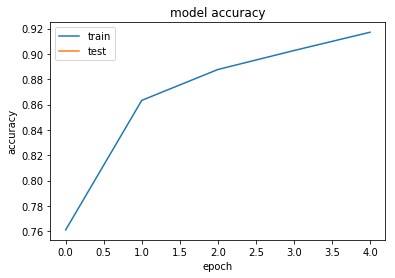

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()



In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [70]:
n=24436
instance = X[n]
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)


In [71]:
print(instance)
model.predict_proba(instance)

[[  21  693 1777    3   21 1008 2113 2113  693 1777 1539    9  139  139
  4616   12   21  898 1777    3 1389   21  693 2079  898 1389 1008  693
   139  898   12    3 1434 1434   21 2113  898   21 1389  693 1113  483
  1434  898   12    9 1807 2113    9   12 1777    3 4616   21 2113  898
  1389  898   12 1539 1113   12   21   21 2113  898  139    3 1807    3
  1807  223 2113    9   12 1389    9 1196 1434  898  483 1113   21    3
  1434   12  693 2113  898   12 2079 1113 1434 1807  898 1389    3  483
  1434  898]]


array([[0.9339113]], dtype=float32)

In [72]:
model.predict_classes(instance)

array([[1]])

In [73]:
print(y[n])

1


In [69]:
df.sample()

,reviews,sentiment
24436,The year is 1896.Jeff Webster (James Stewart) ...,1
